Trước khi tìm hiểu chi tiết về mạng nơ-ron sâu, chúng ta cần nắm vững những kiến thức căn bản của việc huấn luyện mạng nơ-ron. Chương này sẽ đề cập đến toàn bộ quá trình huấn luyện, bao gồm xác định kiến trúc mạng nơ-ron đơn giản, xử lý dữ liệu, chỉ rõ hàm mất mát và huấn luyện mô hình. Để mọi thứ dễ dàng hơn, ta sẽ bắt đầu với một số khái niệm đơn giản nhất. May thay, một số phương pháp học thống kê cổ điển như hồi quy tuyến tính, hồi quy logistic có thể được xem như những mạng nơ-ron nông. Hãy bắt đầu bằng những thuật toán cổ điển này, chúng ta sẽ được giới thiệu những nội dung căn bản nhằm tạo nền tảng cho những kỹ thuật phức tạp hơn như Hồi quy Softmax (sẽ được giới thiệu ở cuối chương này) và Perceptron đa tầng (sẽ được giới thiệu ở chương sau).

In [ ]:
!pip install d2l==1.0.0-beta0

#3.1. Hồi quy Tuyến tính

Hồi quy ám chỉ các phương pháp để xây dựng mối quan hệ giữa điểm dữ liệu  **x**  và mục tiêu với giá trị số thực  *y* . Trong khoa học tự nhiên và khoa học xã hội, mục tiêu của hồi quy thường là đặc trưng hóa mối quan hệ của đầu vào và đầu ra. Mặt khác, học máy lại thường quan tâm đến việc dự đoán.

Bài toán hồi quy xuất hiện mỗi khi chúng ta muốn dự đoán một giá trị số. Các ví dụ phổ biến bao gồm dự đoán giá cả (nhà, cổ phiếu, …), thời gian bệnh nhân nằm viện, nhu cầu trong ngành bán lẻ và vô vàn thứ khác. Không phải mọi bài toán dự đoán đều là bài toán hồi quy cổ điển. Trong các phần tiếp theo, chúng ta sẽ được giới thiệu bài toán phân loại, khi mục tiêu là dự đoán lớp đúng trong một tập các lớp cho trước.

In [2]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


##3.1.1. Các thành phần cơ bản của Hồi quy Tuyến tính

Hồi quy tuyến tính có lẽ là công cụ tiêu chuẩn đơn giản và phổ biến nhất được sử dụng cho bài toán hồi quy. Xuất hiện từ đầu thế kỉ 19, hồi quy tuyến tính được phát triển từ một vài giả thuyết đơn giản. Đầu tiên, ta giả sử quan hệ giữa các đặc trưng  **x**  và mục tiêu  *y*  là tuyến tính, do đó  *y*  có thể được biểu diễn bằng tổng trọng số của đầu vào  **x** , cộng hoặc trừ thêm nhiễu của các quan sát. Thứ hai, ta giả sử nhiễu có quy tắc (tuân theo phân phối Gauss). Để tạo động lực, hãy bắt đầu với một ví dụ. Giả sử ta muốn ước lượng giá nhà (bằng đô la) dựa vào diện tích (đơn vị feet vuông) và tuổi đời (theo năm).

Để khớp một mô hình dự đoán giá nhà, chúng ta cần một tập dữ liệu các giao dịch mà trong đó ta biết giá bán, diện tích, tuổi đời cho từng căn nhà. Trong thuật ngữ của học máy, tập dữ liệu này được gọi là *dữ liệu huấn luyện* hoặc *tập huấn luyện*, và mỗi hàng (tương ứng với dữ liệu của một giao dịch) được gọi là một *ví dụ* hoặc *mẫu*. Thứ mà chúng ta muốn dự đoán (giá nhà) được gọi là *mục tiêu* hoặc *nhãn*. Các biến (tuổi đời và diện tích) mà những dự đoán dựa vào được gọi là các *đặc trưng* hoặc *hiệp biến*.

Thông thường, chúng ta sẽ sử dụng $n$ để biểu thị số ví dụ trong tập dữ liệu của chúng ta. Chúng ta lập chỉ mục các ví dụ dữ liệu bằng $i$, biểu thị mỗi đầu vào là $\mathbf{x}^{(i)} = [x_1^{(i)}, x_2^{(i)}]^\top$ và nhãn tương ứng là $y^{(i)}$. 

###3.1.1.1 Mô hình Tuyến tính
Giả định tuyến tính chỉ nói rằng mục tiêu (giá) có thể được biểu thị dưới dạng tổng trọng số của các tính năng (diện tích và tuổi): 

$$\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b.$$

Ở đây, $w_{\mathrm{area}}$ và $w_{\mathrm{age}}$ được gọi là *trọng số*, và $b$ được gọi là *bias - hệ số điều chỉnh* (còn được gọi là *offset - độ dời* hoặc *intercept*). Các trọng số xác định mức độ đóng góp của mỗi đặc trưng tới đầu ra, còn hệ số điều chỉnh là dự đoán của giá nhà khi tất cả các đặc trưng đều bằng  **0** . Ngay cả khi không bao giờ có một ngôi nhà có diện tích hoặc tuổi đời bằng không, ta vẫn cần sử dụng hệ số điều chỉnh; nếu không khả năng biểu diễn của mô hình tuyến tính sẽ bị suy giảm.

Cho một tập dữ liệu, mục đích của chúng ta là chọn được các trọng số  $w$  và hệ số điều chỉnh  $b$  sao cho dự đoán của mô hình khớp nhất với giá nhà thực tế quan sát được trong dữ liệu.

Trong các bài toán mà tập dữ liệu thường chỉ có một vài đặc trưng, biễu diễn tường minh mô hình ở dạng biểu thức dài như trên khá là phổ biến. Trong học máy, chúng ta thường làm việc với các tập dữ liệu nhiều chiều, vì vậy sẽ tốt hơn nếu ta tận dụng các ký hiệu trong đại số tuyến tính. Khi đầu vào của mô hình có  $d$  đặc trưng, ta biễu diễn dự đoán  $\hat{y}$  bởi

$$\hat{y} = w_1  x_1 + ... + w_d  x_d + b.$$

Thu thập toàn bộ các đặc trưng vào một vector  $x$  và toàn bộ các trọng số vào một vector  $w$ , ta có thể biễu diễn mô hình một cách gọn gàng bằng tích vô hướng:

$$\hat{y} = \mathbf{w}^\top \mathbf{x} + b.$$

Ở đây, vector  $x$ tương ứng với một điểm dữ liệu. Chúng ta sẽ thấy rằng việc truy cập đến toàn bộ tập dữ liệu sẽ tiện hơn nếu ta biểu diễn tập dữ liệu bằng ma trận  $X$ . Mỗi hàng của ma trận  $X$  thể hiện một mẫu và mỗi cột thể hiện một đặc trưng.

Với một tập hợp điểm dữ liệu  $X$ , kết quả dự đoán  $\hat{y}$  có thể được biểu diễn bằng phép nhân giữa ma trận và vector:

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$

Cho một tập dữ liệu huấn luyện  $X$  và các giá trị mục tiêu đã biết trước  $y$ , mục tiêu của hồi quy tuyến tính là tìm vector trọng số  w  và hệ số điều chỉnh  b  sao cho với một điểm dữ liệu mới  $x_i$  được lấy mẫu từ cùng phân phối của tập huấn luyện, giá trị mục tiêu  $y_i$  sẽ được dự đoán với sai số nhỏ nhất (theo kỳ vọng).

Kể cả khi biết rằng mô hình tuyến tính là lựa chọn tốt nhất để dự đoán  $y$  từ  $x$ , chúng ta cũng không kỳ vọng tìm được dữ liệu thực tế mà ở đó  $y$  đúng bằng  $\mathbf{w}^\top \mathbf{x} + b$  với mọi điểm $(x,y)$ . Để dễ hình dung, mọi thiết bị đo lường dùng để quan sát đặc trưng  $X$  và nhãn  $y$  đều có sai số nhất định. Chính vì vậy, kể cả khi ta chắc chắn rằng mối quan hệ ẩn sau tập dữ liệu là tuyến tính, chúng ta sẽ thêm một thành phần nhiễu để giải thích các sai số đó.

Trước khi tiến hành tìm các giá trị tốt nhất cho  $w$  và  $b$ , chúng ta sẽ cần thêm hai thứ nữa: (i) một phép đo đánh giá chất lượng mô hình và (ii) quy trình cập nhật mô hình để cải thiện chất lượng.

### 3.1.1.2. Hàm mất mát

Trước khi suy nghĩ về việc làm thế nào để khớp mô hình với dữ liệu, ta cần phải xác định một phương pháp để đo mức độ khớp. Hàm mất mát định lượng khoảng cách giữa giá trị thực và giá trị dự đoán của mục tiêu. Độ mất mát thường là một số không âm và có giá trị càng nhỏ càng tốt. Khi các dự đoán hoàn hảo, chúng sẽ có độ mất mát sẽ bằng  0 . Hàm mất mát thông dụng nhất trong các bài toán hồi quy là hàm tổng bình phương các lỗi. Khi giá trị dự đoán của một điểm dữ liệu huấn luyện  $i$  là  $\hat{y}^{(i)}$  và nhãn tương ứng là  $y^{(i)}$ , bình phương của lỗi được xác định như sau:

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$

Hằng số  $1/2$  không tạo ra sự khác biệt thực sự nào nhưng sẽ giúp ký hiệu thuận tiện hơn: nó sẽ được triệt tiêu khi lấy đạo hàm của hàm mất mát. Vì các dữ liệu trong tập huấn luyện đã được xác định trước và không thể thay đổi, sai số thực nghiệm chỉ là một hàm của các tham số mô hình. Để tìm hiểu cụ thể hơn, hãy xét ví dụ dưới đây về một bài toán hồi quy cho trường hợp một chiều trong hình dưới.

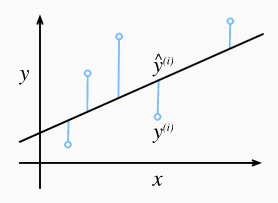

Lưu ý rằng khi hiệu giữa giá trị ước lượng  $\hat{y}^{(i)}$  và giá trị quan sát  $y^{(i)}$  lớn, giá trị hàm mất mát sẽ tăng một lượng còn lớn hơn thế do sự phụ thuộc bậc hai. Để đo chất lượng của mô hình trên toàn bộ tập dữ liệu, ta đơn thuần lấy trung bình (hay tương đương là lấy tổng) các giá trị mất mát của từng mẫu trong tập huấn luyện.

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

Khi huấn luyện mô hình, ta muốn tìm các tham số $( w^∗,b^∗ )$ sao cho tổng độ mất mát trên toàn bộ các mẫu huấn luyện được cực tiểu hóa:

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$



### 3.1.1.3. Nghiệm theo Công thức

Hóa ra hồi quy tuyến tính chỉ là một bài toán tối ưu hóa đơn giản. Khác với hầu hết các mô hình được giới thiệu trong cuốn sách này, hồi quy tuyến tính có thể được giải bằng cách áp dụng một công thức đơn giản, cho một nghiệm tối ưu toàn cục. Để bắt đầu, chúng ta có thể gộp hệ số điều chỉnh  $b$  vào tham số  $w$  bằng cách thêm một cột toàn $1$ vào ma trận dữ liệu. Khi đó bài toán dự đoán trở thành bài toán cực tiểu hóa  $||y−Xw||$ . Bởi vì biểu thức này có dạng toàn phương, nó là một hàm số lồi, và miễn là bài toán này không suy biến (các đặc trưng độc lập tuyến tính), nó là một hàm số lồi chặt.

Bởi vậy chỉ có một điểm cực trị trên mặt mất mát và nó tương ứng với giá trị mất mát nhỏ nhất. Lấy đạo hàm của hàm mất mát theo  w  và giải phương trình đạo hàm này bằng  0 , ta sẽ được nghiệm theo công thức:

$$\mathbf{w}^* = (\mathbf X^\top \mathbf X)^{-1}\mathbf X^\top \mathbf{y}$$

Tuy những bài toán đơn giản như hồi quy tuyến tính có thể có nghiệm theo công thức, bạn không nên làm quen với sự may mắn này. Mặc dù các nghiệm theo công thức giúp ta phân tích toán học một cách thuận tiện, các điều kiện để có được nghiệm này chặt chẽ đến nỗi không có phương pháp học sâu nào thoả mãn được.

### 3.1.1.4 Hạ Gradient

Trong nhiều trường hợp ở đó ta không thể giải quyết các mô hình theo phép phân tích, và thậm chí khi mặt mất mát là các mặt bậc cao và không lồi, trên thực tế ta vẫn có thể huấn luyện các mô hình này một cách hiệu quả. Hơn nữa, trong nhiều tác vụ, những mô hình khó để tối ưu hóa này hoá ra lại tốt hơn các phương pháp khác nhiều, vậy nên việc bỏ công sức để tìm cách tối ưu chúng là hoàn toàn xứng đáng.

Kỹ thuật chính để tối ưu hóa gần như bất kỳ mô hình học sâu nào, sẽ được sử dụng xuyên suốt cuốn sách này, bao gồm việc giảm thiểu lỗi qua các vòng lặp bằng cách cập nhật tham số theo hướng làm giảm dần hàm mất mát. Thuật toán này được gọi là hạ gradient. Trên các mặt mất mát lồi, giá trị mất mát cuối cùng sẽ hội tụ về giá trị nhỏ nhất. Tuy điều tương tự không thể áp dụng cho các mặt không lồi, ít nhất thuật toán sẽ dẫn tới một cực tiểu (hy vọng là tốt).

Ứng dụng đơn giản nhất của hạ gradient bao gồm việc tính đạo hàm của hàm mất mát, tức trung bình của các giá trị mất mát được tính trên mỗi mẫu của tập dữ liệu. Trong thực tế, việc này có thể cực kì chậm. Chúng ta phải duyệt qua toàn bộ tập dữ liệu trước khi thực hiện một lần cập nhật. Vì thế, thường ta chỉ muốn lấy một minibatch ngẫu nhiên các mẫu mỗi khi ta cần tính bước cập nhật. Phương pháp biến thể này được gọi là hạ gradient ngẫu nhiên.

Trong mỗi vòng lặp, đầu tiên chúng ta lấy ngẫu nhiên một minibatch $\mathcal{B}$ dữ liệu huấn luyện với kích thước cố định. Sau đó, chúng ta tính đạo hàm (gradient) của hàm mất mát trên minibatch đó theo các tham số của mô hình. Cuối cùng, gradient này được nhân với tốc độ học  $η>0$  và kết quả này được trừ đi từ các giá trị tham số hiện tại.

Chúng ta có thể biểu diễn việc cập nhật bằng công thức toán như sau ( $∂$  là ký hiệu đạo hàm riêng của hàm số) :

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$

Tổng kết lại, các bước của thuật toán như sau: 
- (i) khởi tạo các giá trị tham số của mô hình, thường thì sẽ được chọn ngẫu nhiên. 
- (ii) tại mỗi vòng lặp, ta lấy ngẫu nhiên từng batch từ tập dữ liệu (nhiều lần), rồi tiến hành cập nhật các tham số của mô hình theo hướng ngược với gradient.

Khi sử dụng hàm mất mát bậc hai và mô hình tuyến tính, chúng ta có thể biểu diễn bước này một cách tường minh như sau: Lưu ý rằng  $w$  và  $x$  là các vector. Ở đây, việc ký hiệu bằng các vector giúp công thức dễ đọc hơn nhiều so với việc biểu diễn bằng các hệ số như  $w_1,w_2,…,w_d$.

$$\begin{aligned} \mathbf{w} & \leftarrow \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) && = \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)\\ b &\leftarrow b -  \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_b l^{(i)}(\mathbf{w}, b) &&  = b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right). \end{aligned}$$



Trong phương trình trên, $|\mathcal{B}|$ là số ví dụ trong mỗi minibatch (kích thước batch) và $η$ là tốc độ học. Cũng cần phải nhấn mạnh rằng các giá trị của kích thước batch và tốc độ học được lựa chọn trước một cách thủ công và thường không được học thông qua quá trình huấn luyện mô hình. Các tham số này tuy điều chỉnh được nhưng không được cập nhật trong vòng huấn luyện, và được gọi là siêu tham số. Điều chỉnh siêu tham số là quá trình lựa chọn chúng, thường dựa trên kết quả của vòng lặp huấn luyện được đánh giá trên một tập kiểm định riêng biệt.

Sau khi huấn luyện đủ số vòng lặp được xác định trước (hoặc đạt được một tiêu chí dừng khác), ta sẽ ghi lại các tham số mô hình đã được ước lượng, ký hiệu là  $\hat{w},\hat{b}$  (ký hiệu “mũ” thường thể hiện các giá trị ước lượng). Lưu ý rằng ngay cả khi hàm số thực sự tuyến tính và không có nhiễu, các tham số này sẽ không cực tiểu hóa được hàm mất mát. Mặc dù thuật toán dần dần hội tụ đến một điểm cực tiểu, nó vẫn không thể tới chính xác được cực tiểu đó với số bước hữu hạn.

Hồi quy tuyến tính thực ra là một bài toán tối ưu lồi, do đó chỉ có một cực tiểu (toàn cục). Tuy nhiên, đối với các mô hình phức tạp hơn, như mạng sâu, mặt của hàm mất mát sẽ có nhiều cực tiểu. May mắn thay, vì một lý do nào đó mà những người làm về học sâu hiếm khi phải vật lộn để tìm ra các tham số cực tiểu hóa hàm mất mát trên dữ liệu huấn luyện. Nhiệm vụ khó khăn hơn là tìm ra các tham số dẫn đến giá trị mất mát thấp trên dữ liệu mà mô hình chưa từng thấy trước đây, một thử thách được gọi là sự khái quát hóa. Chúng ta sẽ gặp lại chủ đề này xuyên suốt cuốn sách.


### 3.1.1.5. Dự đoán bằng Mô hình đã được Huấn luyện

Với mô hình hồi quy tuyến tính đã được huấn luyện  $\hat{w}^⊤x+\hat{b}$ , ta có thể ước lượng giá của một căn nhà mới (ngoài bộ dữ liệu dùng để huấn luyện) với diện tích  $x_1$  và tuổi đời  $x_2$  của nó. Việc ước lượng mục tiêu khi biết trước những đặc trưng thường được gọi là dự đoán hay suy luận (inference).

Ở đây ta sẽ dùng từ dự đoán thay vì suy luận, dù suy luận là một thuật ngữ khá phổ biến trong học sâu, áp dụng thuật ngữ này ở đây lại không phù hợp. Trong thống kê, suy luận thường được dùng cho việc ước lượng thông số dựa trên tập dữ liệu. Việc dùng sai thuật ngữ này là nguyên nhân gây ra sự hiểu nhầm giữa những người làm học sâu và các nhà thống kê.

### 3.1.1.6. Vector hóa để tăng Tốc độ Tính toán

Khi huấn luyện mô hình, chúng ta thường muốn xử lý đồng thời các mẫu dữ liệu trong minibatch. Để làm được điều này một cách hiệu quả, chúng ta phải vector hóa việc tính toán bằng cách sử dụng các thư viện đại số tuyến tính thay vì sử dụng các vòng lặp for trong Python.

Chúng ta sẽ sử dụng hai phương pháp cộng vector dưới đây để hiểu được tại sao vector hóa là cần thiết trong học máy. Đầu tiên, ta khởi tạo hai vector  10000  chiều chứa toàn giá trị một. Chúng ta sẽ sử dụng vòng lặp for trong Python ở phương pháp thứ nhất và một hàm trong thư viện np ở phương pháp thứ hai.

In [3]:
n = 1000
a = torch.ones(n)
b = torch.ones(n)

Ta sẽ bấm giờ với phương pháp chạy vòng for

In [4]:
c = torch.zeros(n)
t=time.time()
for i in range(n):
  c[i] = a[i] + b[i]
f'{time.time() - t:.5f} sec'

'0.03875 sec'

Với toán tử cộng

In [5]:
t = time.time()
d = a + b
f'{time.time() - t:.5f} sec'

'0.00122 sec'

Bạn có thể nhận thấy rằng, phương pháp thứ hai nhanh hơn rất nhiều lần so với phương pháp thứ nhất. Việc vector hóa thường tăng tốc độ tính toán lên nhiều bậc. Ngoài ra, giao phó công việc tính toán cho thư viện để tránh phải tự viết lại sẽ giảm thiểu khả năng phát sinh lỗi.

## 3.1.2. Phân phối Chuẩn và Hàm mất mát Bình phương

Mặc dù bạn đã có thể thực hành với kiến thức được trình bày phía trên, trong phần tiếp theo chúng ta sẽ làm rõ hơn nguồn gốc của hàm mất mát bình phương thông qua các giả định về phân phối của nhiễu.

Nhắc lại ở trên rằng hàm mất mát bình phương  $l(y,\hat{y})=\frac{1}{2}(y−\hat{y})^2$  có nhiều thuộc tính tiện lợi. Việc nó có đạo hàm đơn giản  $∂_\hat{y}l(y,y^)=(\hat{y}−y)$  là một trong số đó.

Như được đề cập trước đó, hồi quy tuyến tính được phát minh bởi Gauss vào năm 1795. Ông cũng là người khám phá ra phân phối chuẩn (còn được gọi là phân phối Gauss). Hóa ra là mối liên hệ giữa phân phối chuẩn và hồi quy tuyến tính không chỉ dừng lại ở việc chúng có chung cha đẻ. Để gợi nhớ lại cho bạn, mật độ xác suất của phân phối chuẩn với trung bình  $μ$  và phương sai  $σ^2$  được cho bởi:


$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right).$$

Dưới đây ta định nghĩa một hàm Python để tính toán phân phối chuẩn.

In [6]:
def normal(x, mu, sigma):
  p = 1/math.sqrt(2*math.pi*sigma**2)
  return p*np.exp(-0.5*(x - mu)**2/sigma**2)

Giờ ta có thể trực quan hóa các phân phối chuẩn.

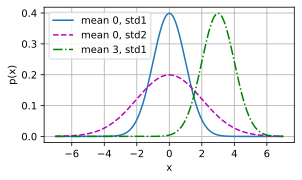

In [7]:
x = np.arange(-7, 7, 0.01)

params = [(0,1), (0,2), (3,1)]
d2l.plot(x, [normal(x, mu, sigma) for mu,sigma in params], xlabel = 'x',
         ylabel = 'p(x)', figsize = (4.5, 2.5),
         legend=[f'mean {mu}, std{sigma}' for mu, sigma in params])

Có thể thấy rằng, thay đổi giá trị trung bình tương ứng với việc dịch chuyển phân phối dọc theo trục x, tăng giá trị phương sai sẽ trải rộng phân phối và hạ thấp đỉnh của nó.

Để thấy rõ hơn mối quan hệ giữa hồi quy tuyến tính và hàm mất mát trung bình bình phương sai số (MSE), ta có thể giả định rằng các quan sát bắt nguồn từ những quan sát nhiễu, và giá trị nhiễu này tuân theo phân phối chuẩn như sau:

$$y = \mathbf{w}^\top \mathbf{x} + b + \epsilon \text{ where } \epsilon \sim \mathcal{N}(0, \sigma^2).$$

Do đó, chúng ta có thể viết khả năng thu được một giá trị cụ thể của  y  khi biết trước  x  là

$$P(y \mid \mathbf{x}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (y - \mathbf{w}^\top \mathbf{x} - b)^2\right).$$

Dựa vào nguyên lý hợp lý cực đại, giá trị tốt nhất của  b  và  w  là những giá trị giúp cực đại hóa sự hợp lý của toàn bộ tập dữ liệu:

$$P(\mathbf y \mid \mathbf X) = \prod_{i=1}^{n} p(y^{(i)} \mid \mathbf{x}^{(i)}).$$

Bộ ước lượng được chọn theo nguyên lý hợp lý cực đại được gọi là bộ ước lượng hợp lý cực đại (Maximum Likelihood Estimators – MLE). Dù việc cực đại hóa tích của nhiều hàm mũ trông có vẻ khó khăn, chúng ta có thể khiến mọi thứ đơn giản hơn nhiều mà không làm thay đổi mục tiêu ban đầu bằng cách cực đại hóa log của hàm hợp lý. Vì lý do lịch sử, các bài toán tối ưu thường được biểu diễn dưới dạng bài toán cực tiểu hóa thay vì cực đại hóa. Do đó chúng ta có thể cực tiểu hóa hàm đối log hợp lý (Negative Log-Likelihood - NLL)  −logp(y|X)  mà không cần thay đổi gì thêm. Kết nối các công thức trên, ta có:

$$-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.$$

Giờ ta chỉ cần thêm một giả định nữa:  $σ$  là một hằng số cố định. Do đó, ta có thể bỏ qua số hạng đầu tiên bởi nó không phụ thuộc vào  $w$  hoặc  $b$ . Còn số hạng thứ hai thì giống hệt hàm bình phương sai số đã được giới thiệu ở trên, nhưng được nhân thêm với hằng số  $\frac{1}{σ^2}$ . May mắn thay, nghiệm không phụ thuộc vào  $σ$ . Điều này dẫn tới việc cực tiểu hóa bình phương sai số tương đương với việc ước lượng hợp lý cực đại cho mô hình tuyến tính dưới giả định có nhiễu cộng Gauss.

## 3.1.3. Từ Hồi quy Tuyến tính tới Mạng Học sâu

Cho đến nay, chúng ta mới chỉ đề cập về các hàm tuyến tính. Trong khi mạng nơ-ron có thể xấp xỉ rất nhiều họ mô hình, ta có thể bắt đầu coi mô hình tuyến tính như một mạng nơ-ron và biểu diễn nó theo ngôn ngữ của mạng nơ-ron. Để bắt đầu, hãy cùng viết lại mọi thứ theo ký hiệu ‘tầng’ (layer).

### 3.1.3.1. Giản đồ Mạng Nơ ron

Những người làm học sâu thích vẽ giản đồ để trực quan hóa những gì đang xảy ra trong mô hình của họ. Trong hình dưới đây, mô hình tuyến tính được minh họa như một mạng nơ-ron. Những giản đồ này chỉ ra cách kết nối (ở đây, mỗi đầu vào được kết nối tới đầu ra) nhưng không có giá trị của các trọng số và các hệ số điều chỉnh.

![Linear regression is a single-layer neural network.](http://d2l.ai/_images/singleneuron.svg)

Vì chỉ có một nơ-ron tính toán (một nút) trong đồ thị (các giá trị đầu vào không cần tính mà được cho trước), chúng ta có thể coi mô hình tuyến tính như mạng nơ-ron với chỉ một nơ-ron nhân tạo duy nhất. Với mô hình này, mọi đầu vào đều được kết nối tới mọi đầu ra (trong trường hợp này chỉ có một đầu ra!), ta có thể coi phép biến đổi này là một tầng kết nối đầy đủ, hay còn gọi là tầng kết nối dày đặc. Chúng ta sẽ nói nhiều hơn về các mạng nơ-ron cấu tạo từ những tầng như vậy trong chương kế tiếp về mạng perceptron đa tầng.

### 3.1.3.2. Sinh vật học

Vì hồi quy tuyến tính (được phát minh vào năm 1795) được phát triển trước ngành khoa học thần kinh tính toán, nên việc mô tả hồi quy tuyến tính như một mạng nơ-ron có vẻ hơi ngược thời. Để hiểu tại sao nhà nghiên cứu sinh vật học/thần kinh học Warren McCulloch và Walter Pitts tìm đến các mô hình tuyến tính để làm điểm khởi đầu nghiên cứu và phát triển các mô hình nơ-ron nhân tạo, hãy xem ảnh của một nơ-ron sinh học tại hình dưới. Mô hình này bao gồm sợi nhánh (cổng đầu vào), nhân tế bào (bộ xử lý trung tâm), sợi trục (dây đầu ra), và đầu cuối sợi trục (cổng đầu ra), cho phép kết nối với các tế bào thần kinh khác thông qua synapses.

![The real neuron.](http://d2l.ai/_images/neuron.svg)

Thông tin  $x_i$  đến từ các nơ-ron khác (hoặc các cảm biến môi trường như võng mạc) được tiếp nhận tại các sợi nhánh. Cụ thể, thông tin đó được nhân với các trọng số của synapses  $w_i$  để xác định mức ảnh hưởng của từng đầu vào (ví dụ: kích hoạt hoặc ức chế thông qua tích  $x_iw_i$ ). Các đầu vào có trọng số đến từ nhiều nguồn được tổng hợp trong nhân tế bào dưới dạng tổng có trọng số  $y= sum_ix_iw_i+b$  và thông tin này sau đó được gửi đi để xử lý thêm trong sợi trục  y , thường là sau một vài xử lý phi tuyến tính qua  $σ(y)$ . Từ đó, nó có thể được gửi đến đích (ví dụ, cơ bắp) hoặc được đưa vào một tế bào thần kinh khác thông qua các sợi nhánh.

## 3.1.4. Bài tập